# Asset e passività

All'inizio del 2000 abbiamo avuto una crisi dei fondi pensione. Da dicembre 1999 a maggio 2003 siamo passati da una attivo di 239 miliardi a un passivo di 252 miliardi con una spaventosa perdita di circa 500 miliardi.

Cosa è successo all'inizio del 2000 abbiamo avuto una bolla sul settore tecnologico con una forte contrazione sul mercato azionario, questo ha fatto ridurre gli attivi dei fondi pensionistici che investivano almeno una parte in azionariato.

Ora se fosse stato solo per il mercato azionario questa cosa sarebbe stata brutta, ma la situazione è passata da brutta a spaventosa.
Il taglio dei tassi di interesse ha fatto abbassare anche i rendimenti delle obbligazioni con il conseguente aumento dei debiti di questi fondi.

La passività di un fondo pensione è simile ad un fondo obbligazionario (il fondo pensione si impegna a restituire il capitale investito più una certa quota di interessi fissi). dunque il taglio dei tassi di interesse ha fatto si che che la passività di questi fondi aumentasse, questa è stata una grave falla nella gestione del rischio. Stessa cosa è accaduta nel 2008.

Concludendo nella gestione patrimoniale ciò che conta è la gestione dell'attivo $A_t$ rispetto al debito $P_t$.

$$
F_t = \frac{A_t}{P_t}
$$

Definiamo come surplus o deficit

$$
S_t = A_t - P_t
$$

Se il valore $F_t$ è maggiore di 100 saremo sicuramente capaci di tener testa ai nostri impegni.

## Valore attuale della passività

Cominciamo con l'esaminare il valore delle passività future per farlo dobbiamo attualizzare il valore futuro, chiameremo questo valore **Present Value** facciamo un esempio pratico.

Supponiamo di dover pagare fra 5 anni $n$ una somma di 1000€ $FV$, diamo come tasso di interesse il 3% $r$ quanto dovrei avere a disposizione ora?

$$
PV = \frac{FV}{(1+r)^n}
$$

Che a conti fatti danno un present value di circa 863€
Ovviamente i tassi di interessi cambiano nel tempo perciò il calcolo della nostra passività sarà di 

$$
PV(L) = \sum_{i=1}^{k} B(t_i) L_i
$$

Il valore $B(t_i)$ rappresenta il valore delle obbligazioni scontate che valgono un euro al tempo $t_i$, se assumiamo che la curva dei rendimenti è piatta e il tasso di interesse è $r$ avremo che

$$
B(t_i) = \frac{1}{(1+r)^t}
$$

iniziamo con l'importazione delle librerie e la scrittura della funzione B

In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays $1 at time t where t is in years and r is the annual interest rate
    """
    return (1+r)**(-t)

Calcoliamo ora il prezzo scontato di un euro di una obbligazione a 10 anni con un tasso di interesse al 3%

In [3]:
b = discount(10, .03)
b

0.7440939148967249

Verifichiamo che il codice sia corretto

In [4]:
b*(1.03**10)

1.0

Abbiamo quello che ci serve possiamo scrivere anche la funzione $PV$

In [5]:
def pv(l, r):
    """
    Compute the present value of a list of liabilities given by the time (as an index) and amounts
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

Assumiamo ora di avere 4 debiti di 1,1.5,2 e 2.5 Milioni di euro. Assumiamo che il primo sia a scadenza di 3 anni e gli altri siano a scadenze di 6 mesi a incrementare. Calcoliamo il valore attualizzato dei debiti.

In [6]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

In [7]:
pv(liabilities, 0.03)

6.233320315080045

Ora assumiamo di calcolare il rapporto di copertura dei finanziamenti **Founding ratio** basandosi sul valore corrente degli attivi:

In [8]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return assets/pv(liabilities, r)

In [9]:
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

abbassiamo il tasso di interessa dal 3% al 2%

In [10]:
funding_ratio(5, liabilities, 0.02)

0.7720304366941648

In [11]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

## Portafoglio a copertura delle passività

Cosa possiamo fare per proteggere il nostro portafoglio dalla passività possiamo usare due strategie:

+ portafoglio a copertura delle passività LHP 
+ portafoglio a copertura degli obiettivi GHP (pensato per investitori individuali)

Nei portafogli di investitori individuali non si parla di passività bensì di obiettivi, come definiamo l'obiettivo?
Definiamo questo come un portafoglio che pagherà o fornirà flussi di cassa che corrisponderanno alla data e l'importo del nostro obiettivo.

Facciamo un semplice esempio, siamo un investitore individuale e siamo nel 2018 assuamiamo che andremo in pensione nel 2035.
Ora dal momento che andremo in pensione avremo bisgono di un importo per i successivi 20 anni (mi sto assumendo il rischio di longevità).

Ora una obbligazione con data di scadenza 2040 non è il nostro investimento migliore in quanto inizierà a pagare le cedole già da subito su base semestrale o annuale, fino alla data di scadenza per poi avere un pagamento. 

Non è quello che vogliamo è una serie di pagamenti legati alla inflazione, ora vogliamo studiare cosa succede quando i tassi di interesse cambiano nel tempo, utilizzeremo il modello CIR.

Iniziamo con il mostrare l'equazione differenziale.

$$
    dr_t = a(b-r_t)dr_t\sigma\sqrt{r_t}dW_t
$$


Prima di iniziare analizziamo il tasso di interessa a breve termine e il tasso di interesse annualizzato.

### Tasso di interesse a breve termine e annualizzato

Il tasso di interesse a breve termine è un tasso di interesse instantaneo (ad esempio 1g) come si calcola questo tasso?
Supponiamo di ricevere 1€ con tasso di interesse al 100% a fine anno dovremmo restituire 1€ più gli interessi per un totale di 2€.

Ora supponiamo di pagare gli interessi ogni 6 mesi cioè 50% metà e 50% a fine anno 

In [12]:
1 + 1*0.5 + 1.5*0.5

2.25

Alziamo l'asticella e supponiamo di pagare gli interessi ogni 4 mesi

In [13]:
1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25)*.25

2.44140625

Possiamo portare questi calcoli in formula generale come:

$$\left(1+\frac{r}{N}\right)^N$$

con $r$ tasso di interesse annuale $N$ numero di frazionamenti

In [14]:
(1+1/2)**2

2.25

In [15]:
(1+1/4)**4

2.44140625

In [16]:
(1+1/12)**12

2.613035290224676

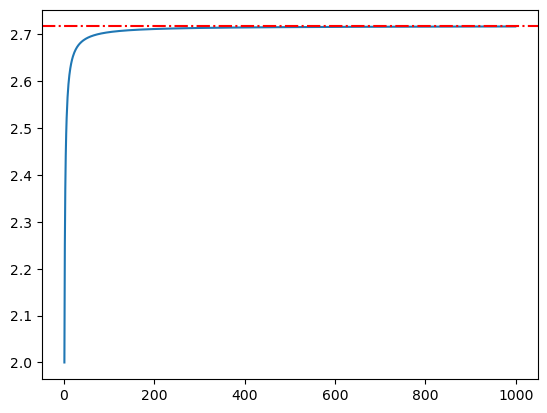

In [17]:
import matplotlib.pyplot as plt


e = np.exp(1)

N = np.arange(1,1000)
r = 1
ret = (1 + r/N)**N
plt.plot(N,ret)

plt.axhline(y=e, color='r', linestyle='-.')

Vediamo subito una cosa interessante la serie converge verso $e$.

Da questo possiamo estrarre le seguenti equazioni:

$$
    1 + r_{ann} = e^{r_{inst}}
$$




$$
    r_{ann} = e^{r_{inst}} - 1
$$

$$
    r_{inst} = ln(1 + r_{ann})
$$

codifichiamo queste equazioni in python

In [18]:
def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.log1p(r)

con queste due funzioni possiamo scrivere il nostro modello CIR (Cox-Ingersoll-Ross)

In [19]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<Axes: >

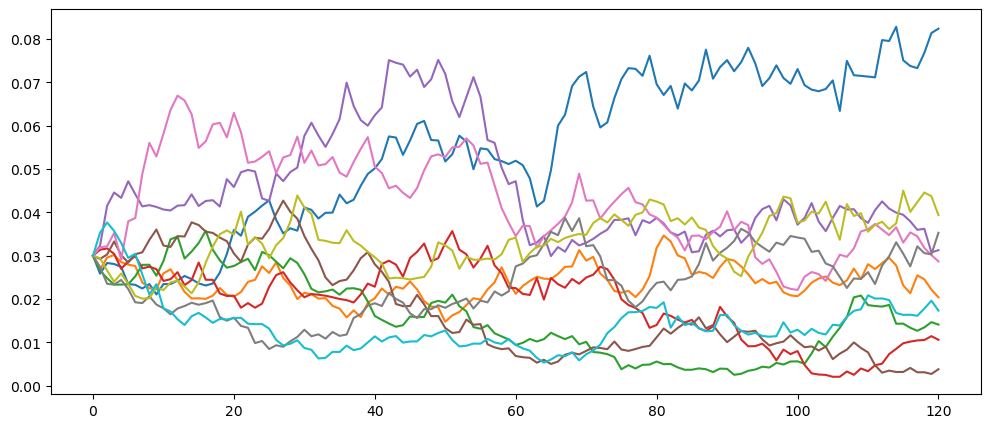

In [20]:
cir(n_scenarios=10).plot(legend=False, figsize=(12,5))

In [21]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Questo modello ci permette di calcolare il prezzo delle **obbligazioni senza cedole** dette anche zero coupon bond 

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

dove

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
e
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
e
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
e
$$ \tau = T-t $$

In [22]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [23]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Simuliamo ora l'andamento tra l'investimento in denaro (conto deposito) e l'investimento in obbligazioni, vediamo che i tassi di interesse influiscono sul risultato finale se i nostro obiettivo è superare o raggiungere 1 il 20% delle volte falliamo

In [24]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

<Axes: title={'center': 'Asset Values using Cash (10 scenarios)'}>

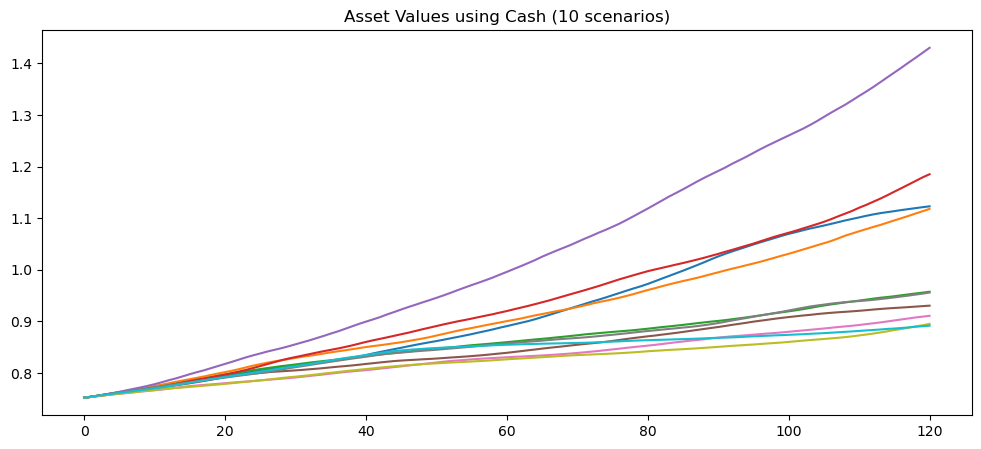

In [25]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5))

Se invece eseguiamo un test sulle obbligazioni senza cedola vediamo che il risultato finale non è influenzato dal cambiamento dei tassi di interesse

<Axes: title={'center': 'Asset Values using ZC Bonds (10 scenarios)'}>

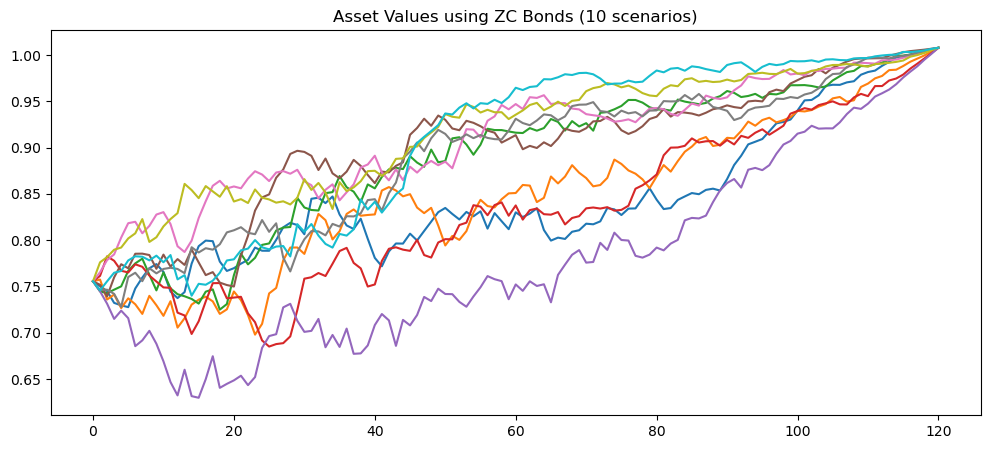

In [26]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

Ragioniamo ora sui rendimenti dell'invetimento in denaro e in obbligazioni

<Axes: title={'center': 'Returns using Cash (10 scenarios)'}>

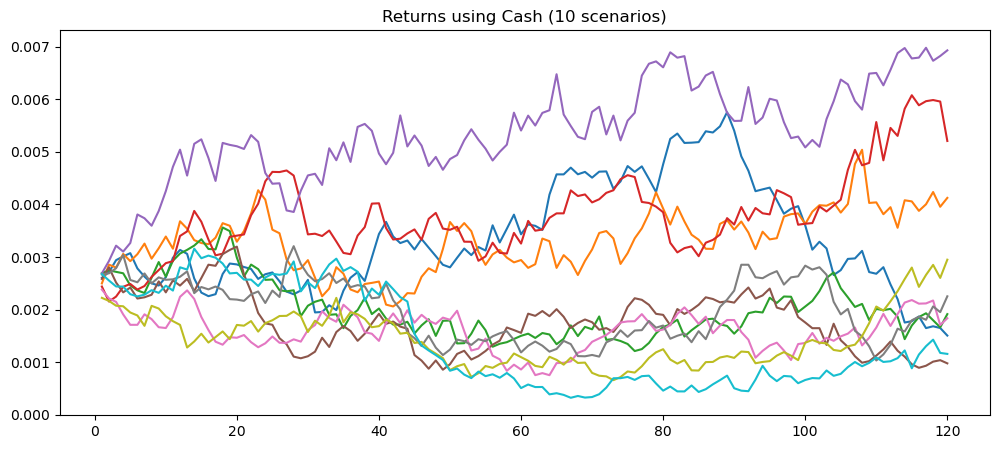

In [27]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns using ZC Bonds (10 scenarios)'}>

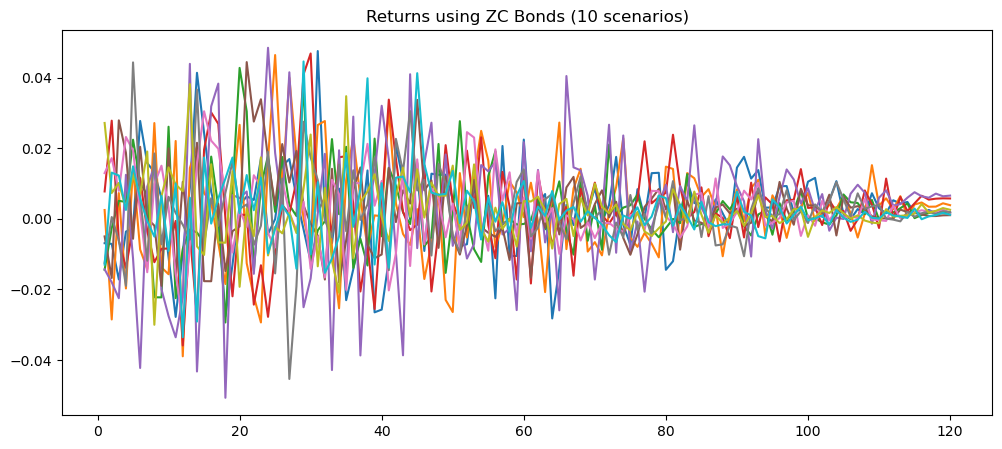

In [28]:
av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

Vediamo anche in termini di founding ratio (rapporto tra attivo e passivo)

<Axes: title={'center': 'Returns of Funding Ratio with Cash (10 scenarios)'}>

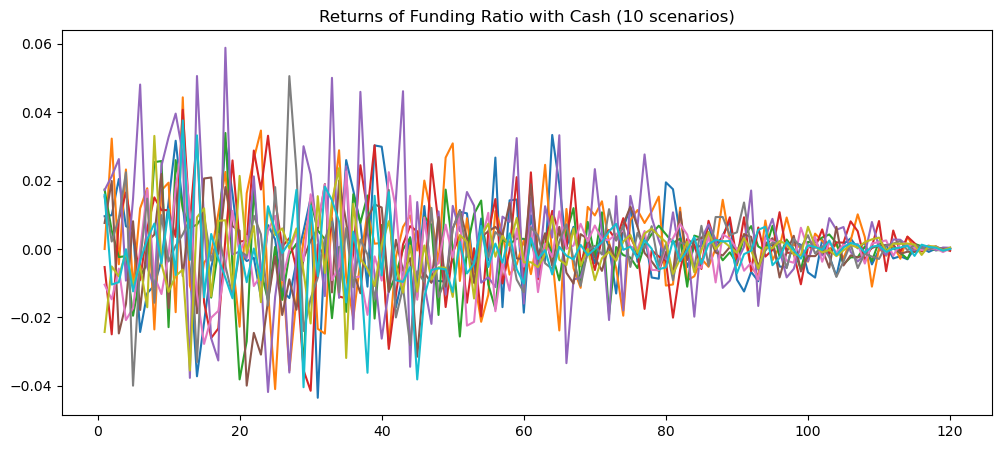

In [29]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns of Funding Ratio with ZC Bonds (10 scenarios)'}>

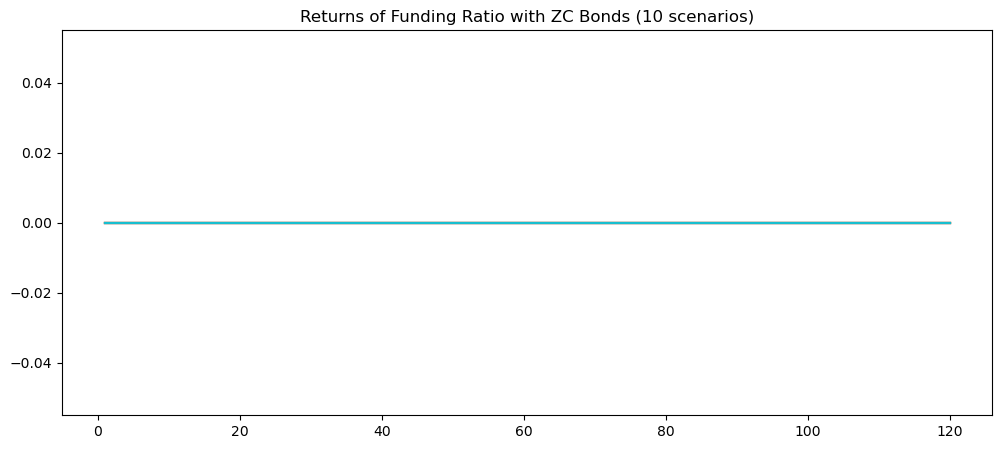

In [30]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

Vediamo che con le obbligazioni il rapporto è stabile, ed è essenzialmente quello che vogliamo avere, analizziamo la distribuzione finale dei valori del founding ratio.

In [31]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

<Axes: >

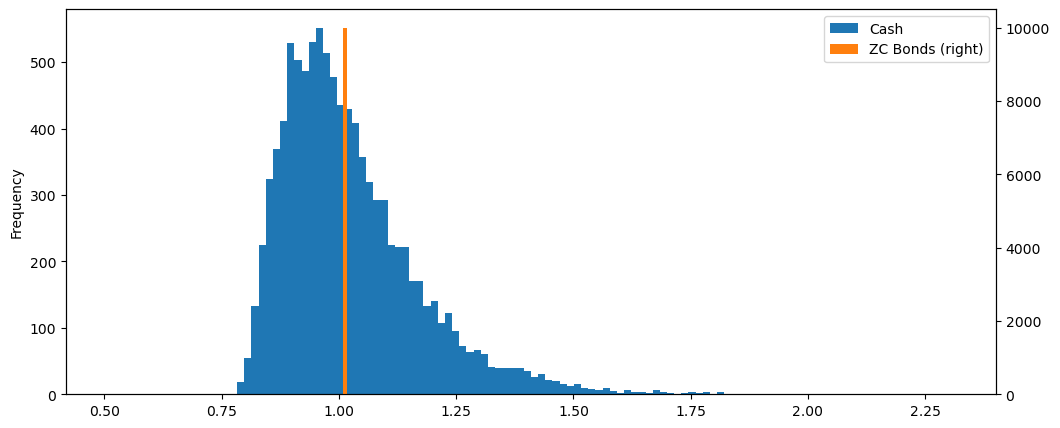

In [32]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)

Come possiamo vedere gli investimenti in denaro possono avere dei risultati finali rischiosi, le obbligazioni senza cedola possono avare delle fluttuazioni importanti durante il percorso ma alla fine arrivano all'obiettivo.

Ovviamente abbiamo fatto due assunzioni per comodità:

* Abbiamo assunto di avere sempre una obbligazione disponibile per la data scadenza voluta
* Abbiamo beni inziali per poterci permettere la copertura

Cercheremo di superare questi due punti con i prossimi appunti


https://www.performancetrading.it/Documenti.htm